In [1]:
%load_ext autoreload
%autoreload 2

from multiprocessing import cpu_count
import os
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.loggers.neptune import NeptuneLogger
import ray
import seaborn
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from nemo.data.dataloader import TrialAvgNeuralDataset
from nemo.model.analysis.feature_visualization import write_simple_cell_strfs
from nemo.model.models import ElasticNet
from nemo.model.layers import Identity
from nemo.model.utils import tune_model

# "Population" Model

## Set Parameters

Hyper-parameter values to search over

In [2]:
alphas = ray.tune.uniform(0.0, 1.0)
lambdas = ray.tune.loguniform(1e-5, 1.0)
lrs = ray.tune.loguniform(1e-3, 1e-1)
batch_sizes = 256
loss_fns = torch.nn.MSELoss()
input_norms = ray.tune.choice([
    torch.nn.BatchNorm1d,
    torch.nn.LayerNorm,
    None
])
act_norms = ray.tune.choice([
    torch.nn.BatchNorm1d,
    torch.nn.LayerNorm,
    None
])
optims = torch.optim.SGD
act_fns = None
n_tune_samples = 40

Dataset Parameters

In [3]:
n_frames = 9
stim_height = 40 
stim_width = 64
train_stim = ['natural_movie_three']
val_stim = ['natural_movie_two']
test_stim = ['natural_movie_one']

Data Loader Parameters

In [4]:
n_workers = 10

Trainer and Model Args

In [5]:
n_gpu_tune = 0.5
max_steps = 10000
n_cpu_tune = 6
patience = 5
tol = 1e-6
model_name = 'population_full'

## Initialize the Dataset

In [6]:
dset = TrialAvgNeuralDataset(
    data_dir = '../../data/AIBO/VISp/L4/Exc/ExtractedData',
    stimuli = train_stim + val_stim + test_stim,
    stim_height = stim_height,
    stim_width = stim_width,
    n_frames = n_frames,
    col_transform = lambda x: x.divide(x.abs().max())
)

INFO -- 04/06/2021 11:59:24 PM -- Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
/home/mteti/NEMO/nemo/model/analysis/metrics.py:164: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(SP / true.groupby('stimulus').var())
INFO -- 04/07/2021 12:00:41 AM -- DATASET INITIALIZED
INFO -- 04/07/2021 12:00:41 AM --    - NEURAL DATA DIR: ../../data/AIBO/VISp/L4/Exc/ExtractedData/NeuralData
INFO -- 04/07/2021 12:00:41 AM --    - STIMULI DATA DIR: ../../data/AIBO/VISp/L4/Exc/ExtractedData/Stimuli
INFO -- 04/07/2021 12:00:41 AM --    - STIMULI: ['natural_movie_three', 'natural_movie_two', 'natural_movie_one']
INFO -- 04/07/2021 12:00:41 AM --    - CRE LINES: None
INFO -- 04/07/2021 12:00:41 AM --    - NUM. CELLS: 5353
INFO -- 04/07/2021 12:00:41 AM --    - NUM. ANIMALS: 45
INFO -- 04/07/2021 12:00:41 AM --    - NUM. STIMULUS FRAMES: 5400


In [7]:
dset.data

,stimulus,frame,517397343_511498742,517397347_511498742,517397357_511498742,517397441_511498742,517397464_511498742,517397474_511498742,517397528_511498742,517397564_511498742,...,738948440_712178509,738948535_712178509,738948566_712178509,738948605_712178509,738948646_712178509,738948685_712178509,738948725_712178509,738948770_712178509,738948842_712178509,738948929_712178509
0,natural_movie_one,0.0,-0.010422,0.004444,-0.009537,-0.078491,0.001704,-0.008606,0.284424,0.013405,...,0.014351,-0.015656,-0.081177,0.001443,0.008263,-0.046112,-0.015480,0.037415,0.025589,-0.047089
1,natural_movie_one,1.0,0.074036,-0.022018,-0.017807,0.015762,-0.039795,0.007526,0.286865,0.003563,...,0.050629,0.043823,-0.043304,-0.012413,0.050842,-0.016510,0.017593,0.004734,0.032410,0.031738
2,natural_movie_one,2.0,0.012741,-0.055664,-0.017517,-0.015282,0.021881,-0.037933,0.258301,0.006096,...,0.030197,-0.019760,-0.093323,-0.033539,-0.017731,-0.033752,-0.031464,0.007153,0.021713,-0.028183
3,natural_movie_one,3.0,0.067871,0.002438,0.011116,0.082336,0.023987,0.045044,0.220703,0.006897,...,0.043152,0.094299,-0.084961,-0.061462,-0.020569,0.044830,0.004925,-0.004425,0.002554,-0.040924
4,natural_movie_one,4.0,0.043518,0.051575,0.027542,0.043091,-0.001768,0.002468,0.167725,0.012466,...,0.032349,0.028671,-0.020996,-0.048401,0.024414,0.017715,0.022720,0.011963,0.023315,0.046600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,natural_movie_two,895.0,-0.000597,0.154907,0.015579,0.036316,0.068665,0.066162,-0.023529,-0.000123,...,0.036194,-0.031677,0.057556,0.123840,0.089111,0.105591,0.050781,0.058990,0.153442,-0.002123
5396,natural_movie_two,896.0,0.026871,0.136719,-0.001554,0.013878,0.034363,0.009903,0.017181,-0.007790,...,-0.002495,-0.089966,-0.018768,-0.134521,0.007736,0.077942,0.040588,0.009178,0.085693,-0.011238
5397,natural_movie_two,897.0,-0.083130,0.156494,0.009636,0.070190,0.034698,-0.009804,-0.001986,0.001776,...,-0.003206,0.046173,0.173950,-0.059906,0.103271,-0.107483,0.034271,0.081543,0.058655,-0.130127
5398,natural_movie_two,898.0,0.035095,0.110413,0.017670,0.001190,0.075928,-0.058716,-0.005875,0.004822,...,-0.048157,0.023407,-0.006702,-0.026566,0.003452,0.171631,0.057159,0.035065,0.059082,-0.020096


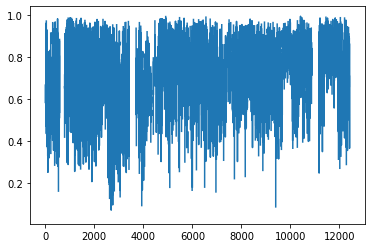

In [8]:
plt.plot(dset.cc_max[dset.cc_max.index == test_stim[0]].to_numpy()[0])

Text(96.0, 0.5, 'Neuron')

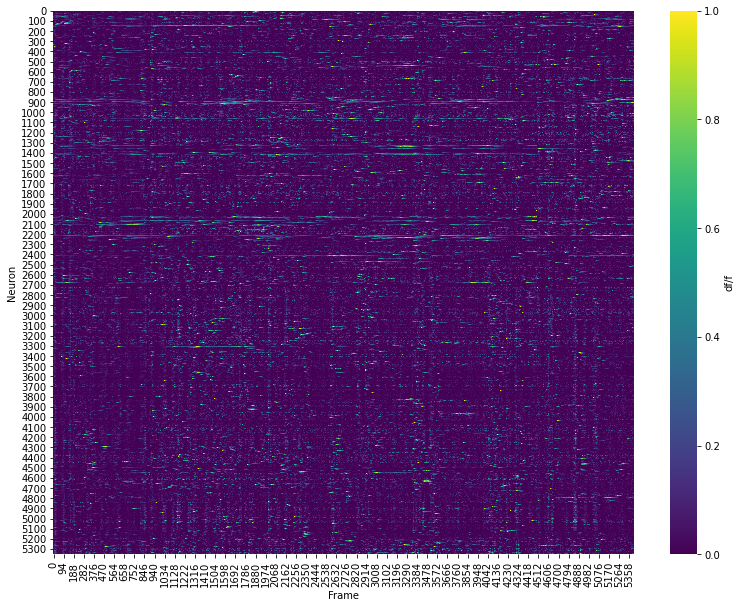

In [9]:
fig = plt.figure(figsize = (13, 10))
seaborn.heatmap(
    data = dset.data.set_index(['stimulus', 'frame']).to_numpy().transpose(),
    cmap = 'viridis',
    vmin = 0.0,
    cbar_kws = {'label': 'df/f'}
)
plt.xlabel('Frame')
plt.ylabel('Neuron')

In [10]:
train_inds = dset.data.index[dset.data.stimulus.isin(train_stim)].to_list()
val_inds = dset.data.index[dset.data.stimulus.isin(val_stim)].to_list()
test_inds = dset.data.index[dset.data.stimulus.isin(test_stim)].to_list()
print(len(train_inds), len(val_inds), len(test_inds), len(set(train_inds) & set(test_inds) & set(val_inds)))

3600 900 900 0


## Run Hyper-Parameter Search

In [11]:
ray.init(include_dashboard = False)

{'node_ip_address': '192.168.1.15',
 'raylet_ip_address': '192.168.1.15',
 'redis_address': '192.168.1.15:6379',
 'object_store_address': '/tmp/ray/session_2021-04-07_00-00-58_731202_20400/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-07_00-00-58_731202_20400/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-04-07_00-00-58_731202_20400',
 'metrics_export_port': 63159,
 'node_id': 'a86c71ee7e4727ca979d4c57cbf520d2f5dfa773635d25e4e64a6b6b'}

In [12]:
config = {
    'lr': lrs,
    'alpha': alphas,
    'lambd': lambdas,
    'act_fn': act_fns,
    'loss_fn': loss_fns,
    'optim': optims,
    'input_norm_fn': input_norms,
    'norm_fn': act_norms,
    'batch_size': batch_sizes,
    'n_neurons': len(dset.cell_ids),
    'in_h': stim_height,
    'in_w': stim_width,
    'n_frames': n_frames,
    'patience': patience,
    'tol': tol
}

In [ ]:
analysis = ray.tune.run(
    ray.tune.with_parameters(
        tune_model,
        ptl_model = ElasticNet,
        dset = dset,
        train_inds = train_inds,
        val_inds = val_inds,
        n_workers = n_workers,
        tune_metrics = {'loss': 'val_loss'},
        mode = 'tune',
        gpus = int(np.ceil(n_gpu_tune)),
        max_steps = max_steps,
        check_val_every_n_epoch = 1,
        progress_bar_refresh_rate = 0,
        weights_summary = None
    ),
    config = config,
    num_samples = n_tune_samples,
    resources_per_trial = {'cpu': n_cpu_tune, 'gpu': n_gpu_tune},
    verbose = 1, 
    metric = 'loss',
    mode = 'min',
    local_dir = os.path.join(os.getcwd(), model_name),
    checkpoint_freq = 0
)

In [ ]:
analysis.best_config

In [16]:
result_df = analysis.results_df

In [17]:
len(result_df)

50

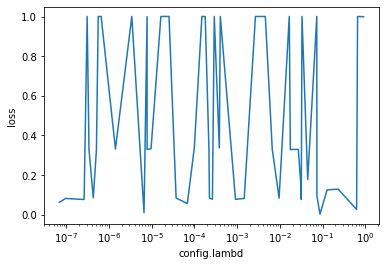

In [18]:
seaborn.lineplot(
    data = result_df,
    x = 'config.lambd',
    y = 'loss'
)
plt.xscale('log')
plt.show()

## Retrain a Model on Train + Val Datasets With Optimal Hyper-parameters

In [19]:
trainer = tune_model(
    config = analysis.best_config,
    ptl_model = ElasticNet,
    dset = dset,
    train_inds = train_inds + val_inds,
    n_workers = cpu_count() - 4,
    val_inds = train_inds + val_inds,
    mode = 'train',
    gpus = n_gpu_tune,
    max_steps = max_steps,
    check_val_every_n_epoch = 1,
    progress_bar_refresh_rate = 50,
    log_every_n_steps = 5,
    logger = NeptuneLogger(
        api_key = os.environ['NEPTUNE_API_TOKEN'],
        project_name = 'mteti/neural-encoding-elasticnet',
        experiment_name = 'population_model',
        params = {
            k: v.real if k in ['alpha', 'lr', 'lambd'] else v 
            for k, v in analysis.best_config.items()
        }
    )
)

NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


https://ui.neptune.ai/mteti/neural-encoding-elasticnet/e/ELASTICNET-34



  | Name          | Type        | Params
----------------------------------------------
0 | loss_fn       | MSELoss     | 0     
1 | act_fn        | Identity    | 0     
2 | norm_fn       | Identity    | 0     
3 | input_norm_fn | BatchNorm1d | 46.1 K
4 | strf          | Linear      | 123 M 
----------------------------------------------
123 M     Trainable params
0         Non-trainable params
123 M     Total params
493.538   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]      
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=1.12e+04, v_num=T-34]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=7.66e+03, v_num=T-34]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=4.29e+03, v_num=T-34]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=4.16e+03, v_num=T-34]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=4.16e+03, v_num=T-34]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it, loss=4.16e+03, v_num=T-34]


## Test the Model on the Test Movie

### View the Weights

In [33]:
best_model = trainer.get_model()

In [34]:
best_weights = best_model.strf.weight.detach().cpu().numpy()
best_weights = best_weights.reshape([-1, n_frames, stim_height, stim_width])
best_weights = [best_weights[:, frame_num, ...][:, None, None, None] for frame_num in range(n_frames)]
print(best_weights[0].shape)
write_simple_cell_strfs(best_weights, './population_mse_loss_no_bias_one_neuron')

(5353, 1, 1, 1, 40, 64)


### Create a Test Data Loader and Get the Loss on the Test Set

In [35]:
test_dl = DataLoader(
    dset,
    batch_size = analysis.best_config['batch_size'],
    num_workers = n_workers,
    sampler = SequentialSampler(test_inds),
    drop_last = False
)

In [36]:
trainer.test(best_model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 100%|██████████| 2/2 [00:12<00:00,  6.25s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.13218097388744354}
--------------------------------------------------------------------------------


[{'test_loss': 0.13218097388744354}]

### Predict on Test Samples

In [37]:
preds = np.zeros([len(test_inds), len(dset.cell_ids)])
true = preds.copy()
test_bs = test_dl.batch_size

for batch_num, batch in enumerate(test_dl):
    y = batch[1][-1]
    batch = ([x.cuda() for x in batch[0]], [y.cuda() for y in batch[1]])
    y_hat = best_model.predict_step(batch, batch_num)
    preds[batch_num * test_bs: (batch_num + 1) * test_bs] = y_hat.detach().cpu().numpy()
    true[batch_num * test_bs: (batch_num + 1) * test_bs] = y.numpy()

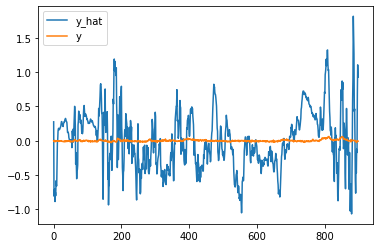

In [38]:
plt.plot(preds[:, 2], label = 'y_hat')
plt.plot(true[:, 2], label = 'y')
plt.legend()
plt.show()